In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("../")

from cfd_rigolli import Cfd_rigolli

%load_ext autoreload
%autoreload 2


In [2]:
hws = pd.read_hdf('/home/gorilla/An/data/WindyMASigned.h5') 
cfd = Cfd_rigolli(dirname="../data/rigolli/")

In [19]:
# Check the scaled range of x_coords and y_coords
x_coords_scaled = cfd.x_coords
y_coords_scaled = cfd.y_coords

print("Scaled x-coords range:", x_coords_scaled.min(), x_coords_scaled.max())
print("Scaled y-coords range:", y_coords_scaled.min(), y_coords_scaled.max())

# Expected range should be [0, 40] for x and [2, 8] for y based on your plot


Scaled x-coords range: 7.017962 56.0
Scaled y-coords range: 0.047456200000000004 29.6


In [25]:
cfd.get_odor_at_position_and_time((10,5),10)

array(12.18590639)

In [ ]:
# odor = []
# for i in range(25000,30000):
#     odor.append(cfd_instance.get_odor_at_position_and_time((hws.xsrc[i],hws.ysrc[i]),150))
# plt.plot(odor)

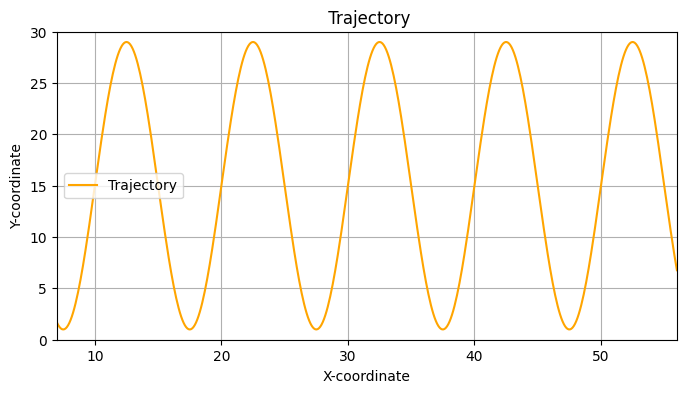

In [55]:
x = np.linspace(56, 7, 500)

y = 15 + 14 * np.sin((10 * np.pi / 50) * x)
plt.figure(figsize=(8, 4))
plt.plot(x, y, label='Trajectory', color='orange')
plt.title(' Trajectory')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.xlim(7, 56)
plt.ylim(0, 30)
plt.grid(True)
plt.legend()
plt.show()

In [32]:
odor = []
for i in range(len(x)):
    odor.append(cfd.get_odor_at_position_and_time((x[i],y[i]),20))

Text(0, 0.5, 'odor,a.u.')

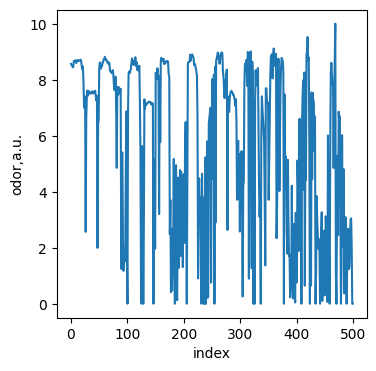

In [47]:
f,ax=plt.subplots(1,1,figsize=(4,4))
ax.plot(scale_data(odor))
ax.set_xlabel('index')
ax.set_ylabel('odor,a.u.')

In [49]:
import seaborn as sns

/home/gorilla/An/arunavanag/lib/python3.10/site-packages/seaborn/distributions.py:2125: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


Text(0, 0.5, 'odor,a.u.')

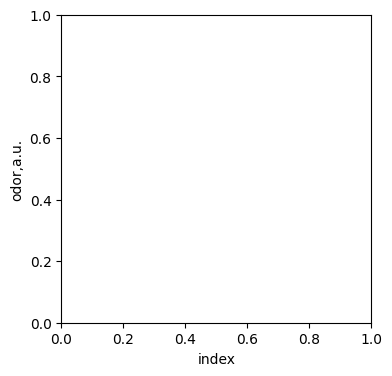

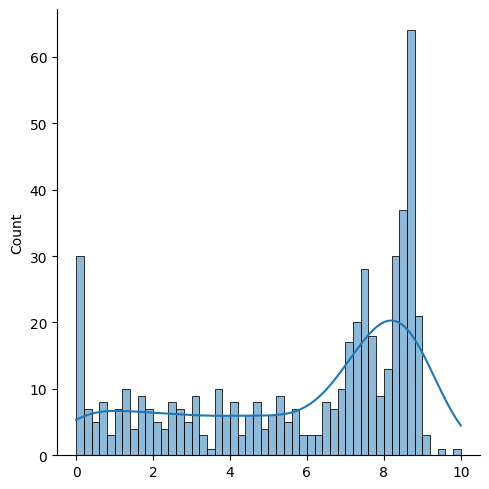

In [53]:

f,ax=plt.subplots(1,1,figsize=(4,4))
sns.displot(scale_data(odor), kde='True', bins=50, ax=ax)
ax.set_xlabel('index')
ax.set_ylabel('odor,a.u.')

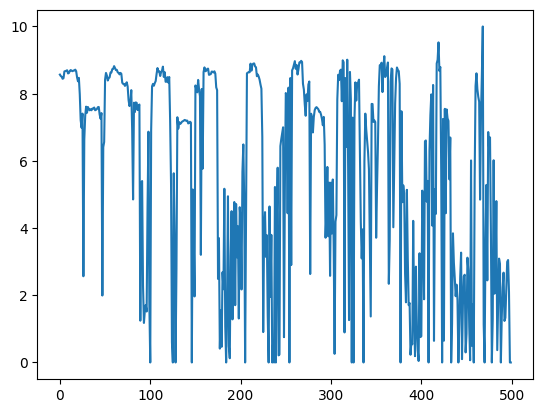

In [34]:
def scale_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (((data - min_val) / (max_val - min_val)) * 10)
plt.plot(scale_data(odor))

In [3]:
# Load libraries
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import h5py
import os
from multiprocessing import Pool, cpu_count
dirname="../data/rigolli/"
# File names and keys
files = ['nose_data.mat', 'ground_data.mat', 'downwind_v.mat', 'crosswind_v.mat', 'vertical_v.mat']
keys = ['nose', 'ground', 'uu', 'vv', 'ww']
fnames = [f"{dirname}/{f}" for f in files]
for f in fnames:
    if not os.path.exists(f):
        raise ValueError(f"File {f} does not exist")

hdf_files = [h5py.File(f, 'r') for f in fnames]

coord = sio.loadmat(f"{dirname}/coordinates.mat")
x_coords = coord['X'].flatten()
y_coords = coord['Y'].flatten()

# Apply scaling factors to match the new coordinate ranges
scale_length_x = 50 / (x_coords.max() - x_coords.min())
scale_length_y = 30 / (y_coords.max() - y_coords.min())

x_coords = x_coords * scale_length_x
y_coords = y_coords * scale_length_y - 15  # Center y around 0 and range from -15 to 15

time_max = hdf_files[0]['nose'].shape[0] - 1

def plot_frame(t):
    print(f"Plotting frame {t}")
    figcol = 3
    figrow = 2
    fig, axs = plt.subplots(figrow, figcol, figsize=(15, 10))
    axs = (ax for ax in axs.flatten())
    
    for i, (f, k) in enumerate(zip(hdf_files, keys)):
        ax = next(axs)
        if k in ['nose', 'ground']:
            data = f[k][t + 1, :, :]
            data[data <= 0] = 1e-20
            data = np.log10(data)
            vmin = -6
            vmax = -3
        else:
            data = f[k][t, :, :]
            vmin = -50
            vmax = 50
        
        kk = ax.contourf(x_coords, y_coords, data, vmin=vmin, vmax=vmax, cmap='viridis', levels=100)
        ax.set_title(k)
        ax.set_aspect('equal')
        ax.set_xlim(0, 50)  # Set the x-axis range to match the target
        ax.set_ylim(-15, 15)  # Set the y-axis range to match the target
        fig.colorbar(kk, ax=ax)
        
    fig.suptitle('t = {:04d}'.format(t))
    fig.tight_layout()
    fig.savefig(f'all_frames/fig_{t:04d}.png', dpi=300)
    plt.close(fig)

num_cores = cpu_count()
num_tasks = min(num_cores, time_max // 1000 + 1)
pool = Pool(processes=num_tasks)


pool.map(plot_frame, range(0, 100, time_max))

pool.close()
pool.join()


Plotting frame 0


In [4]:
import cv2
import os
from natsort import natsorted

# Specify the folder containing the images and the output video file
image_folder = 'all_frames'  # Replace with your folder path
video_filename = 'output_video.mp4'  # Change to .mp4

# Get a list of all image files in the folder, sorted naturally (numerical order)
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images = natsorted(images)  # Ensures images are in numerical order if named accordingly

# Check if there are images
if not images:
    raise ValueError("No .png images found in the specified folder!")

# Read the first image to get video dimensions
first_image = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = first_image.shape

# Create a video writer object for .mp4 output
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' codec for .mp4 output
fps = 30  # Frames per second, adjust as needed
video = cv2.VideoWriter(video_filename, fourcc, fps, (width, height))

# Add images to the video
for image in images:
    img_path = os.path.join(image_folder, image)
    frame = cv2.imread(img_path)
    video.write(frame)

# Release the video writer
video.release()

print(f"Video {video_filename} has been created successfully!")


Video output_video.mp4 has been created successfully!
